# Identify, Retrieve and  Export  Near-Cloud-Free Landsat Images 

### Fei Zhang @Geoscience Australia

Sept 2016

## Introduction


### Key Topics: 

1) 
2) 

## Interactive Computing

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
import math
import pandas

import sys
sys.path.insert(0, '/g/data/u46/fxz547/Githubz/agdc-v2')#'/home/547/fxz547/myGithub/agdc-v2')  #prepend a path

In [2]:
# import AGDC Python API modules

import datacube
from datacube.storage import masking

# Create an API data access object
dc = datacube.Datacube(app='GetData')

dc

Datacube<index=Index<db=PostgresDb<engine=Engine(postgresql://fxz547@130.56.244.227:6432/datacube)>>>

We can access the Postgres Database (metadata index) and its associated imagery data.

## Datacube Products List 
The Datacube provides pandas.DataFrame representations of the available products and measurements:

In [3]:
# df_prodlist = dc.list_products()

# df_prodlist.shape

In [4]:
# df_prodlist.head()

## Measurements List of the Products

- Each of the datacube products may have multiple measurements.

- Measurements are related to the sensors characteristics,  also known as _bands_ in the remote-sensing domain.

- _bands_ comes from electromagnetic wave spectral ranges, generally include Red-Green-Blue (RGB). 

In [5]:
df_measlist = dc.list_measurements()

print(df_measlist.shape)

(90, 7)


In [6]:
df_measlist.head(10)

aliases    dtype flags_definition  \
product            measurement                                              
bom_rainfall_grids rainfall                 NaN  float32              NaN   
dsm1sv10           elevation                NaN  float32              NaN   
ls5_fc_albers      BS                    [bare]     int8              NaN   
                   PV               [green_veg]     int8              NaN   
                   NPV               [dead_veg]     int8              NaN   
                   UE                     [err]     int8              NaN   
ls5_nbar_albers    blue          [band_1, blue]    int16              NaN   
                   green        [band_2, green]    int16              NaN   
                   red            [band_3, red]    int16              NaN   
                   nir            [band_4, nir]    int16              NaN   

                                     name nodata  \
product            measurement                     
bom_rainfall_grids rainfall      rainfall   -999   
dsm1sv10           elevation    elevation    NaN   
ls5_fc_albers      BS                  BS     -1   
                   PV                  PV     -1   
                   NPV                NPV     -1   
                   UE                  UE     -1   
ls5_nbar_albers    blue              blue   -999   
                   green            green   -999   
                   red                red   -999   
                   nir                nir   -999   

                                                              spectral_definition  \
product            measurement                                                      
bom_rainfall_grids rainfall                                                   NaN   
dsm1sv10           elevation                                                  NaN   
ls5_fc_albers      BS                                                         NaN   
                   PV                                                         NaN   
                   NPV                                                        NaN   
                   UE                                                         NaN   
ls5_nbar_albers    blue         {u'wavelength': [410, 411, 412, 413, 414, 415,...   
                   green        {u'wavelength': [500, 501, 502, 503, 504, 505,...   
                   red          {u'wavelength': [580, 590, 600, 605, 610, 611,...   
                   nir          {u'wavelength': [730, 735, 740, 745, 750, 751,...   

                                  units  
product            measurement           
bom_rainfall_grids rainfall          mm  
dsm1sv10           elevation      metre  
ls5_fc_albers      BS           percent  
                   PV           percent  
                   NPV          percent  
                   UE                 1  
ls5_nbar_albers    blue               1  
                   green              1  
                   red                1  
                   nir                1

## Retrieving data stack over AOI


In [7]:
itime=1

def show_images(nbar, itime):
    """ Display single band images; select a time-slice of the imagery stack
          use pandas-style slicing to select a time period
    """
    
    print ("Showing images acquired in datetime ", nbar.time.values[itime])
    
    red_img=nbar.red.isel(time=itime)
    green_img=nbar.green.isel(time=itime)
    blue_img = nbar.blue.isel(time=itime)


    plt.figure( figsize=(16,14) )
    
    plt.subplot( 1,3,1 )
    plt.imshow(red_img)#, cmap='gray')
    plt.title("Red band"); plt.xlabel('easting'); plt.ylabel('northing')
    plt.colorbar(orientation='vertical', shrink=0.3, label='red sensor measurement');

    
    plt.subplot( 1,3,2 )
    plt.imshow(green_img)   # plotting the subset data directly
    #plt.imshow(green_img, cmap='gray')
    plt.title("Green band"); plt.xlabel('easting'); plt.ylabel('northing')
    plt.colorbar(orientation='vertical', shrink=0.3, label='green sensor measurement');


    plt.subplot( 1,3,3 )
    plt.imshow(blue_img)   # plotting the subset data directly
    #plt.imshow(blue_img, cmap='gray')
    plt.title("Blue band"); plt.xlabel('easting'); plt.ylabel('northing')
    plt.colorbar(orientation='vertical', shrink=0.3, label='blue sensor measurement');

    return


In [8]:
# define a scale function to stretch an image 

def scale_array(arr, prcnt, min_val, max_val, nan_val):
    """
    Linearly scales array 'arr' at the 'prcnt' percentile between 'min_val' and 'max_val', 
    replacing 'nan_val' values with NaN's.
    #f_arr = 1.0*arr #.astype('float')    # required for NaN's 
    """
  
    f_arr = arr.astype('float')
    #f_arr[f_arr==nan_val] = np.nan
    prcnt_delta = (100-prcnt)/2
    clip_lim = np.nanpercentile(f_arr,(prcnt_delta,100-prcnt_delta))
    f_arr = np.clip(f_arr,clip_lim[0],clip_lim[1])
    f_arr = (f_arr-clip_lim[0]) / (clip_lim[1]-clip_lim[0])
    f_arr = f_arr * (max_val-min_val) + min_val
    
    return f_arr

def scale_array2(arr, prcnt, min_val, max_val, nan_val):
    """
    Linearly scales array 'arr' fake_saturation value. 
    If the surf reflectance value is too large, it will be set as fake_saturation.
    What happen to the -999 values?
    
    return scaled  2D array image with value in (0,255)
    """
  
    fake_saturation = 3000
    
    #f_arr = arr.astype('float')
    #f_arr[f_arr==nan_val] = np.nan
    
    clipped_arr= arr.where(arr<fake_saturation).fillna(fake_saturation)
   
    return (255*clipped_arr)/fake_saturation

In [9]:
def make_rgb_images(nbar, itime, outfname=None):
    """
    Create a RGB image using bands acquired at itime
    """
    print ("RGB image acquired in datetime ", nbar.time.values[itime])
        
    plt.figure( figsize=(10,10) )
    
    red_img=nbar.red.isel(time=itime)
    green_img=nbar.green.isel(time=itime)
    blue_img = nbar.blue.isel(time=itime)
    y_size = red_img.shape[0]; x_size = red_img.shape[1]

    print (y_size,x_size)
    #print red_img.shape

    
    rgb_image = np.zeros((y_size, x_size, 3), dtype='uint8')
    
    #rgb_image = np.zeros((y_size, x_size, 3), dtype='int16') #not work int16	-32,768 to 32,767

    nodatav=nbar.red.nodata
    percent =99.99
    maxv=255 # 32767
    sB1data = scale_array2(red_img, percent, 0, maxv, nodatav)
    sB2data = scale_array2(green_img, percent, 0, maxv, nodatav)
    sB3data = scale_array2(blue_img, percent, 0, maxv, nodatav)

    rgb_image[:,:,0] = sB1data; 
    rgb_image[:,:,1] = sB2data; 
    rgb_image[:,:,2] = sB3data
    
    strDate=str(nbar.time.values[itime])[:10]
    title_str= 'Landsat Image over the Area: %s, %s, %s'%(str(xp), str(yp), strDate)
    plt.title(title_str)
    plt.ylabel('Northing'); plt.xlabel('Easting');
    
    if outfname is None:
        plt.imshow(rgb_image)
        output_figure_name = 'nbar_nature_color.png'
        plt.savefig(output_figure_name, dpi=400)
    else:
        plt.imsave(outfname, rgb_image)  #only the image would NOT save the title and axis label
        plt.close()
    


# Export to geotiff raster file

In [10]:
import rasterio

DEFAULT_PROFILE = {
    'blockxsize': 256,
    'blockysize': 256,
    'compress': 'lzw',
    'driver': 'GTiff',
    'interleave': 'band',
    'nodata': 0.0,
    'photometric': 'RGA',    #'RGBA',
    'tiled': True}


def write_geotiff(filename, dataset, time_index=None, profile_override=None):
    """
    Write an xarray dataset to a geotiff filename

    :attr bands: ordered list of dataset names
    :attr time_index: the time index of data slice to be output to file
    :attr dataset: xarray dataset containing multiple bands to write to file
    :attr profile_override: option dict, overrides rasterio file creation options.
    """
    profile_override = profile_override or {}

    dtypes = {val.dtype for val in dataset.data_vars.values()}
    assert len(dtypes) == 1  # Check for multiple dtypes

    profile = DEFAULT_PROFILE.copy()
    profile.update({
        'width': dataset.dims[dataset.crs.dimensions[1]],
        'height': dataset.dims[dataset.crs.dimensions[0]],
        'affine': dataset.affine,
        'crs': dataset.crs.crs_str,
        'count': len(dataset.data_vars),
        'dtype': str(dtypes.pop()),
        'nodata': dataset.red.nodata
    })
    profile.update(profile_override)

    with rasterio.open(filename, 'w', **profile) as dest:
        for bandnum, data in enumerate(dataset.data_vars.values(), start=1):
            dest.write(data.isel(time=time_index).data, bandnum)

In [11]:
# export dataset of xarray.Dataset
import os

def export_datasets(ds, fn_prefix):
    """
    loop over every datasets in ds, output geotiff and rgb image
    see the filtered version below
    """
    for itime in xrange (0,len(ds.time)):
        #fntime=str(ds.time.values[itime])[:19].replace(':','')
        fntime=str(ds.time.values[itime])[:10].replace(':','')
        fname ="%s_%s.tiff"%(fn_prefix,fntime)
        fname2="%s_%s.png"%(fn_prefix,fntime)
        
        path2fname=os.path.join("/short/v10/fxz547/Dexport",fname)
        path2fname2 =os.path.join("/short/v10/fxz547/Dexport",fname2)

        write_geotiff(path2fname,ds, itime)
        
        make_rgb_images(ds, itime, path2fname2 )
        
        

## Main starts: Clean and near-cloudless images in AGDC


### Derive information products 

### Must identify and remove invalid observations: cloud, shadow, satuared pixels

### Band maths: combine the bands to derive new variables (artificial bands)

-  Normalized Difference Vegetation Index, NDVI
-  Normalized Difference Water Index,  NDWI
-  These index can help to clearly identify certain land cover features: Vegetation, water bodies


### Group  by solar day function

- There is a bit of overlap between two adjacent scenes ("cut").
- To remove the overlap duplication, we combine the data slices with datetimes less than a minute apart.  
- Now we have fewer timeslices than found previously without solar-day-grouping
- According to Landsat cycle 16 days, 365/16 = 22 re-visit a place at least per year 

(For some region like Canberra, there will be overlap between passes)
Can be checked in the Clear Observation Layer at: http://eos-test.ga.gov.au/geoserver/www/remote_scripts/WOfS_v1.6.htm

In [12]:
# Select best RGB NDVI NDWI images: eg,70% good valid pixels

Good_Pixels_Pct=50

# Defina an Area of Interest

# Where?
# AOI_NAME = 'LakeBG';xp = (149.07, 149.17); yp = (-35.25, -35.35)  #Lake Burley Griffin
# xp=( 149.160,  149.170); yp=(-35.34 , -35.35 )  #a small area cover GA water pond

#GungahlinACT
AOI_NAME = 'CanberraNorth'; xp= (149.061024, 149.163758); yp=(-35.217105, -35.151768)

AOI_NAME = 'Lake_George';
xp = (149.28, 149.53);
yp = (-34.98, -35.25)  # Lake George area

# Edge of fire scar (NT) 19:36:10.24S//132:34:55.72E
# 0.1degree =~ 10km
AOI_NAME = 'FireScarNT';  xp = (132.50, 132.60);    yp = (-19.65, -19.55)

# Farming land (crops (green and fallow paddocks - Western NSW)30:5:45.33S/148:11:29.75E
AOI_NAME='Farmland'; xp=(148.14, 148.24); yp=(-30.15, -30.05)

# Woodland (greenish most of the time. the understory should change in response to seasonal drying out)22:52:35.4S/147:24:11.25E
AOI_NAME='Woodland'; xp=(147.35, 147.45); yp=(-22.92, -22.82)


# When? a time range
tp = ('2013-01', '2013-12-31')

# what product type?
prod_type = 'ls8_nbar_albers'
# associated pq product code
pq_prod_type = prod_type.replace('nbar', 'pq')

# output grid and resolution?
v_output_crs = None;
v_resolution = None  # None if AGDC default

# v_output_crs='EPSG:3112'; v_resolution=(-25,25)  #LCC 3112, Albers 3577
# output_crs='EPSG:4326', resolution=(-0.00025, 0.00025)

In [13]:
#  retrieve a subset of bands
#bands = dc.load(product=prod_type, x=xp, y=yp, time=tp, group_by='solar_day',
#        measurements=['red', 'nir', 'green', 'swir1','blue'])

# retrieve all bands
bands = dc.load(product=prod_type, x=xp, y=yp, time=tp, group_by='solar_day')

bands = masking.mask_valid_data(bands)
red = bands.red
nir = bands.nir
green = bands.green
swir1 = bands.swir1

# red = bands.red.where(bands.red != bands.red.attrs['nodata'])
# nir = bands.nir.where(bands.nir != bands.nir.attrs['nodata'])
                    
# green = bands.green.where(bands.green != bands.green.attrs['nodata'])
# swir1 = bands.swir1.where(bands.swir1 != bands.swir1.attrs['nodata'])



# Retrieve the associated Pixel Quality datasets. pq has issue with group_by_solar_day 
# They may not match all the Nbar products
pq = dc.load(product=pq_prod_type, x=xp, y=yp,  time=tp, group_by='solar_day') #, fuse_func='')

# cloud_free = masking.make_mask(pq, cloud_acca='no_cloud', cloud_fmask='no_cloud', contiguous=True).pixelquality
# below mask is better, can remove blank immage LS8-2013-06-11 which ndvi=0
# to get perfect good pixels, how about cloud shadows?
cloud_free = masking.make_mask(pq, cloud_acca='no_cloud', cloud_fmask='no_cloud',
                               cloud_shadow_acca='no_cloud_shadow', cloud_shadow_fmask='no_cloud_shadow',
                               contiguous=True).pixelquality

- The returned data is an `xarray.Dataset` object, which is a labelled n-dimensional array wrapping a `numpy` array.

- We can investigate the data to see the variables (measurement bands) and dimensions 

- We can look at the data by name directly, or through the `data_vars` dictionary:


In [14]:
#nbar vs pq
print (bands.dims)
print (pq.dims)

print(bands.geobox); 
print(pq.geobox)


print (bands.indexes)
print (pq.indexes)

Frozen(SortedKeysDict({'y': 494, 'x': 458, 'time': 27}))
Frozen(SortedKeysDict({'y': 494, 'x': 458, 'time': 27}))
GeoBox([(147.33688543876767, -22.821251125929624), (147.3514415707951, -22.93093380626375), (147.46330355575537, -22.91861179376906), (147.44864342630004, -22.80893883227614)])
GeoBox([(147.33688543876767, -22.821251125929624), (147.3514415707951, -22.93093380626375), (147.46330355575537, -22.91861179376906), (147.44864342630004, -22.80893883227614)])
time: DatetimeIndex(['2013-03-26', '2013-04-24', '2013-05-01', '2013-05-17',
                     '2013-06-11', '2013-06-18', '2013-06-27', '2013-07-04',
                     '2013-07-13', '2013-07-20', '2013-07-29', '2013-08-05',
                     '2013-08-14', '2013-08-21', '2013-08-30', '2013-09-06',
                     '2013-09-15', '2013-09-22', '2013-10-24', '2013-11-02',
                     '2013-11-09', '2013-11-18', '2013-11-25', '2013-12-04',
                     '2013-12-11', '2013-12-20', '2013-12-27'],
      

In [15]:
# pq and nbar are not necesarily match!! in the imperfect world.

print(pq.time.min())
print(pq.time.max())
pq.dims


<xarray.DataArray 'time' ()>
numpy.datetime64('2013-03-26T11:00:00.000000000+1100')
<xarray.DataArray 'time' ()>
numpy.datetime64('2013-12-27T11:00:00.000000000+1100')


Frozen(SortedKeysDict({'y': 494, 'x': 458, 'time': 27}))

In [16]:
# inspect the xarray.Datasets 


def ds_profile(dataset):

    print(dataset.time.min())
    print(dataset.time.max())
    print (dataset.crs)
    print(dataset.data_vars)
    print (dataset.coords)


    dtypes = {val.dtype for val in dataset.data_vars.values()}
    assert len(dtypes) == 1  # Check for multiple dtypes
    profile={
        'width': dataset.dims[dataset.crs.dimensions[1]],
        'height': dataset.dims[dataset.crs.dimensions[0]],
        'affine': dataset.affine,
        'crs': dataset.crs.crs_str,
        'count': len(dataset.data_vars),
        'dtype': str(dtypes.pop()),
        'nodata': dataset.red.nodata
        }
    
    print profile
    
    return profile

In [17]:
ds_profile(bands)

<xarray.DataArray 'time' ()>
numpy.datetime64('2013-03-26T11:00:00.000000000+1100')
<xarray.DataArray 'time' ()>
numpy.datetime64('2013-12-27T11:00:00.000000000+1100')
EPSG:3577
Data variables:
    coastal_aerosol  (time, y, x) float64 515.0 496.0 484.0 500.0 508.0 ...
    blue             (time, y, x) float64 440.0 429.0 419.0 424.0 423.0 ...
    green            (time, y, x) float64 503.0 496.0 499.0 526.0 513.0 ...
    red              (time, y, x) float64 497.0 479.0 473.0 508.0 508.0 ...
    nir              (time, y, x) float64 1.192e+03 1.16e+03 1.142e+03 ...
    swir1            (time, y, x) float64 1.149e+03 1.029e+03 1.022e+03 ...
    swir2            (time, y, x) float64 721.0 649.0 644.0 669.0 668.0 ...
Coordinates:
  * time     (time) datetime64[ns] 2013-03-26 2013-04-24 2013-05-01 ...
  * y        (y) float64 -2.552e+06 -2.552e+06 -2.552e+06 -2.552e+06 ...
  * x        (x) float64 1.556e+06 1.556e+06 1.556e+06 1.556e+06 1.556e+06 ...
{'count': 7, 'crs': 'EPSG:3577', 'dtyp

{'affine': Affine(25.0, 0.0, 1556100.0,
       0.0, -25.0, -2552225.0),
 'count': 7,
 'crs': 'EPSG:3577',
 'dtype': 'float64',
 'height': 494,
 'nodata': -999,
 'width': 458}

### Compute Indexes: NDVI and NDWI

#### Numpy array arithmetics without looping

In [18]:

# Normalized Differenc Vegetation Index: Red and near Infrared bands
ndvi = ((nir - red) / (nir + red)).where(cloud_free)

# Normalized Differenc Water Index: Green and Shortwave Infrared Bands
#del(ndwi)
#ndwi = ((swir1- green)/(green + swir1)).where(cloud_free)

ndwi = ((green- swir1)/(green + swir1)).where(cloud_free)

ndvi.shape


(27, 494, 458)

In [19]:
ndwi.shape

(27, 494, 458)

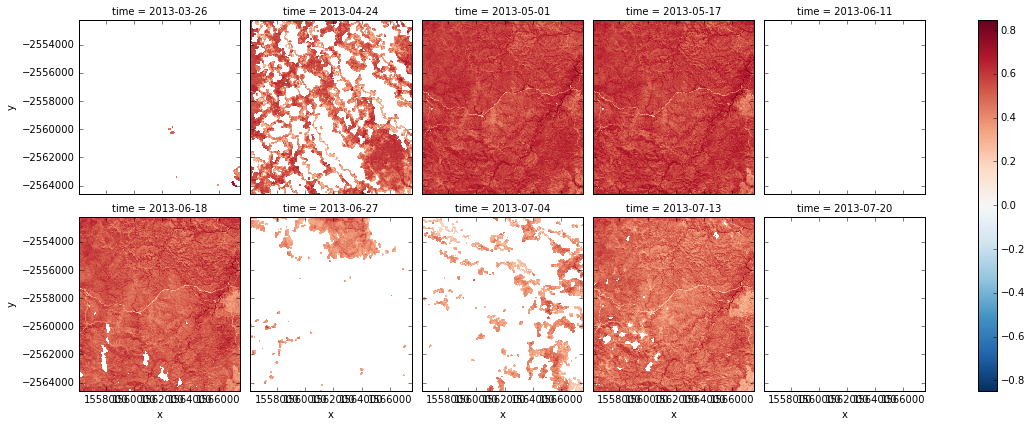

In [20]:
# skip ndvi plots 
ndvi[:10].plot(col='time', col_wrap=5)

In [21]:
#check the images pixel values, nan
im=1
ndvi[im]

<xarray.DataArray (y: 494, x: 458)>
array([[ 0.54875887,  0.55827664,  0.58139535, ...,         nan,
                nan,         nan],
       [ 0.55796787,  0.56285589,  0.58238035, ...,         nan,
                nan,         nan],
       [ 0.56313131,  0.5672465 ,  0.58009709, ...,         nan,
                nan,         nan],
       ..., 
       [        nan,         nan,  0.41292812, ...,         nan,
                nan,         nan],
       [        nan,         nan,  0.42145964, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan]])
Coordinates:
    time     datetime64[ns] 2013-04-24
  * y        (y) float64 -2.552e+06 -2.552e+06 -2.552e+06 -2.552e+06 ...
  * x        (x) float64 1.556e+06 1.556e+06 1.556e+06 1.556e+06 1.556e+06 ...

In [22]:
# check the cloud masks images

cloud_free[im]
#plt.imshow(cloud_free[im])

<xarray.DataArray 'pixelquality' (y: 494, x: 458)>
array([[ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       ..., 
       [False, False,  True, ..., False, False, False],
       [False, False,  True, ..., False, False, False],
       [False, False, False, ..., False, False, False]], dtype=bool)
Coordinates:
  * y        (y) float64 -2.552e+06 -2.552e+06 -2.552e+06 -2.552e+06 ...
  * x        (x) float64 1.556e+06 1.556e+06 1.556e+06 1.556e+06 1.556e+06 ...
    time     datetime64[ns] 2013-04-24

###  Weed out the low quality images.

In [23]:
# xarray.Dataset.sum to reduce the datasets by selecting the time slices with high percentage cloud-free pixels


Good_Pixels_Pct=50  # percentage of good-cloudfree pixels of all valid pixels (ie. exclude the nan-valued)

# note, there are some totally blank image all-nan images will be excluded!!
cloudfreeRatio = 0.01*Good_Pixels_Pct # threshold of cloud pixel 80% ??

mostly_cloud_free = cloud_free.sum(dim=('x','y')) > (cloudfreeRatio * cloud_free.size / cloud_free.time.size)

# reduced to a 1D dataArray with time as index, boolean values
print(mostly_cloud_free)


<xarray.DataArray 'pixelquality' (time: 27)>
array([False, False,  True,  True, False,  True, False, False,  True,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False,  True,  True,  True,  True,  True], dtype=bool)
Coordinates:
  * time     (time) datetime64[ns] 2013-03-26 2013-04-24 2013-05-01 ...


In [24]:
# How many images selected?  (counting the number of True)

print(mostly_cloud_free.sum().values)

20


In [25]:
def get_good_image_times(mostly_cloud_free):
    """
    collect the timestamps of less cloudy images
    """
    seltimes=[]
    for itime in xrange(0,len(mostly_cloud_free)):  
        if mostly_cloud_free[itime].values:
            print (itime, mostly_cloud_free[itime].values, mostly_cloud_free[itime].time.values )
            seltimes.append(mostly_cloud_free[itime].time.values)

    print (seltimes[:2] )
    
    return seltimes

In [26]:
def filter_export_datasets(ds, ndvi, fn_prefix, times):
    """
    export the images from a subset of the input dataset ds, using filter times
    """
    for itime in xrange(0,len(ds.time)):
        #print (ds.time.values[itime])
        if ds.time.values[itime] in times:
            print (itime)
            
            fntime=str(ds.time.values[itime])[:10].replace(':','')
            fname ="%s_%s.tiff"%(fn_prefix,fntime)
            fname2="%s_%s.png"%(fn_prefix,fntime)
            
            path2fname=os.path.join("/short/v10/fxz547/Dexport",fname)
            path2fname2 =os.path.join("/short/v10/fxz547/Dexport",fname2)

            write_geotiff(path2fname,ds, itime)

            make_rgb_images(ds, itime, path2fname2 )
            
    # OK           
    return
        


In [27]:

fnpref = '%s_%s_NBAR' % (AOI_NAME, prod_type[:3])

good_times = get_good_image_times(mostly_cloud_free)

filter_export_datasets(bands, ndvi, fnpref, good_times)

(2, array(True, dtype=bool), numpy.datetime64('2013-05-01T10:00:00.000000000+1000'))
(3, array(True, dtype=bool), numpy.datetime64('2013-05-17T10:00:00.000000000+1000'))
(5, array(True, dtype=bool), numpy.datetime64('2013-06-18T10:00:00.000000000+1000'))
(8, array(True, dtype=bool), numpy.datetime64('2013-07-13T10:00:00.000000000+1000'))
(10, array(True, dtype=bool), numpy.datetime64('2013-07-29T10:00:00.000000000+1000'))
(11, array(True, dtype=bool), numpy.datetime64('2013-08-05T10:00:00.000000000+1000'))
(12, array(True, dtype=bool), numpy.datetime64('2013-08-14T10:00:00.000000000+1000'))
(13, array(True, dtype=bool), numpy.datetime64('2013-08-21T10:00:00.000000000+1000'))
(14, array(True, dtype=bool), numpy.datetime64('2013-08-30T10:00:00.000000000+1000'))
(15, array(True, dtype=bool), numpy.datetime64('2013-09-06T10:00:00.000000000+1000'))
(16, array(True, dtype=bool), numpy.datetime64('2013-09-15T10:00:00.000000000+1000'))
(17, array(True, dtype=bool), numpy.datetime64('2013-09-22

<xarray.DataArray 'pixelquality' (y: 494, x: 458)>
array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ..., 
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]], dtype=bool)
Coordinates:
  * y        (y) float64 -2.552e+06 -2.552e+06 -2.552e+06 -2.552e+06 ...
  * x        (x) float64 1.556e+06 1.556e+06 1.556e+06 1.556e+06 1.556e+06 ...
    time     datetime64[ns] 2013-05-01
('RGB image acquired in datetime ', numpy.datetime64('2013-05-01T10:00:00.000000000+1000'))
(494, 458)


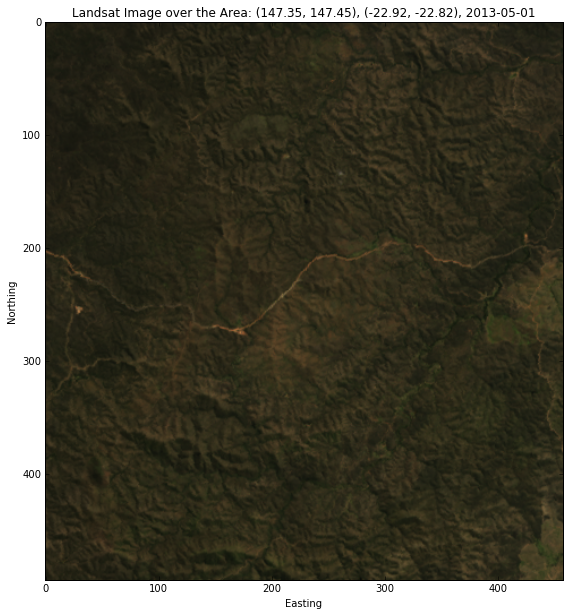

In [37]:
# check cloud mask
im=2
print(cloud_free[im])
#plt.imshow(cloud_free[i])

##!ffmpeg -r 1 -pattern_type glob -i 'Dexport/CleanImages_LakeGorge_*.png' -c:v libx264 LS78.mp4

# Display the nearly cloud free images [0, 8, 9, 11, 12, 20, 24, 26, 30, 32, 34]

make_rgb_images(bands, im)


In [29]:
# export a xarray 
        
def export_mdarray(ndvi, fn_prefix):
    """
    export ndvi images array
    """
    
    for itime in xrange (0,len(ndvi.time)):
        fntime=str(ndvi.time.values[itime])[:10].replace(':','')
       
        fndvi="%s_%s_ndvi.png"%(fn_prefix,fntime)
        path2ndvi =os.path.join("/short/v10/fxz547/Dexport",fndvi)
            
        plt.imsave(path2ndvi, ndvi.isel(time=itime))
  
        #plt.imsave(path2fname2, mostly_good_ndwi.isel(time=itime),cmap='brg')
    
    return

In [30]:
# Apply the time-dim mask to the 3D-array (time, x, y)
mostly_good_ndvi = ndvi.where(mostly_cloud_free).dropna('time', how='all')

export_mdarray(mostly_good_ndvi, fnpref)



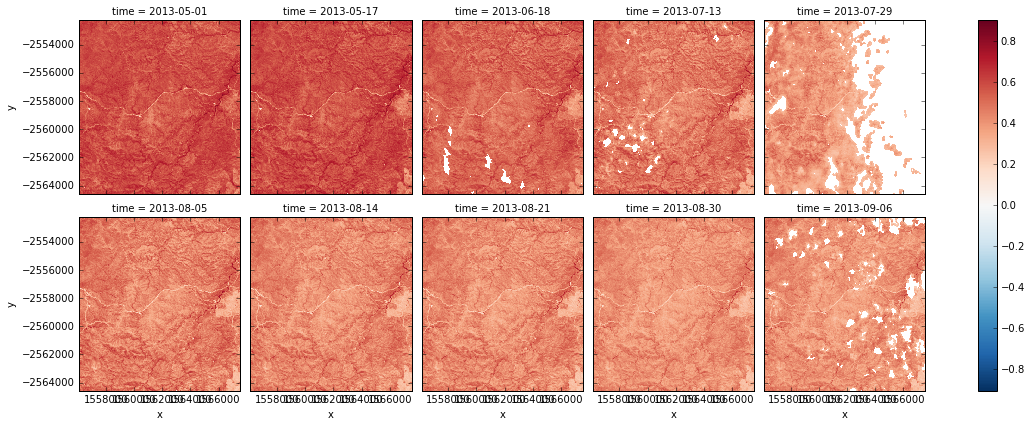

In [31]:
mostly_good_ndvi[:10].plot(col='time', col_wrap=5)


In [32]:
mostly_good_ndvi.isel(time=3)

<xarray.DataArray (y: 494, x: 458)>
array([[ 0.45920985,  0.49307774,  0.50668648, ...,  0.633235  ,
         0.61821004,  0.57277255],
       [ 0.47903305,  0.49065184,  0.50280183, ...,  0.64239723,
         0.62944664,  0.60378408],
       [ 0.46869245,  0.50575816,  0.52147806, ...,  0.6226784 ,
         0.61484453,  0.60455487],
       ..., 
       [ 0.56193896,  0.57427536,  0.56691254, ...,  0.37808972,
         0.35905045,  0.30377574],
       [ 0.58963093,  0.57040573,  0.57040359, ...,  0.38313831,
         0.36722488,  0.33583381],
       [ 0.57434641,  0.60339343,  0.55204216, ...,  0.37154737,
         0.35388335,  0.35023585]])
Coordinates:
    time     datetime64[ns] 2013-07-13
  * y        (y) float64 -2.552e+06 -2.552e+06 -2.552e+06 -2.552e+06 ...
  * x        (x) float64 1.556e+06 1.556e+06 1.556e+06 1.556e+06 1.556e+06 ...

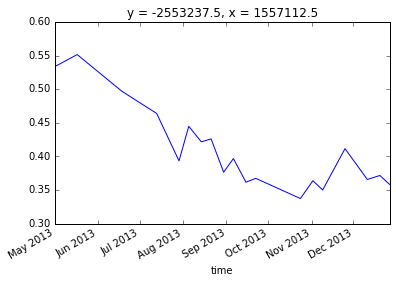

In [33]:
#https://github.com/data-cube/agdc-v2/blob/develop/examples/notebooks/Datacube_Summary.ipynb
# pixel drill
mostly_good_ndvi.isel(x=[40], y=[40]).plot()

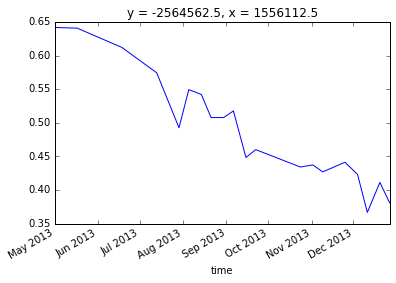

In [34]:
#How to export xarray.DataArray (time: 11, y: 490, x: 420) into geotiff?

mostly_good_ndvi.sel(y=-3955361, x=1549813, method='nearest').plot()

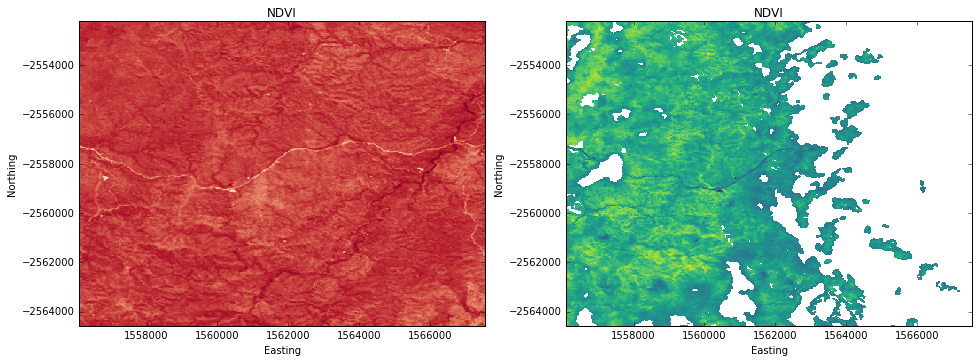

In [40]:
plt.figure( figsize=(16,12) )    
plt.subplot( 2,2,1 )
mostly_good_ndvi[0].plot(add_colorbar=False)
plt.title("NDVI"); plt.xlabel('Easting'); plt.ylabel('Northing')


plt.subplot( 2,2,2 )
mostly_good_ndvi[4].plot(add_colorbar=False)
# ndvi.mean(dim='time').plot()
plt.title("NDVI"); plt.xlabel('Easting'); plt.ylabel('Northing')


In [35]:
stop here

SyntaxError: invalid syntax (<ipython-input-35-f9ef205a8f26>, line 1)

## Normalised Difference Water Index

In [ ]:
# images after removed invalid pixels. 
#ndwi.plot(col='time', col_wrap=5)


### Weed out the low quality images.

In [ ]:
# apply the cloud_threshold mask, which will select a subset images with good pixels. 

mostly_good_ndwi = ndwi.where(mostly_cloud_free).dropna('time', how='all')

mostly_good_ndwi.plot(col='time', col_wrap=5)

In [ ]:
plt.imsave('NDWI.png', mostly_good_ndwi.isel(time=5),cmap='brg')

In [ ]:
len(mostly_good_ndwi.time)

In [ ]:

??? why ds
def export_mdarray(ds, fn_prefix):
    for itime in xrange (0,len(ds.time)):
        fntime=str(ds.time.values[itime])[:10].replace(':','')
        #fname ="%s_%s.tiff"%(fn_prefix,fntime)
        #path2fname=os.path.join("/short/v10/fxz547/Dexport",fname)
        #write_geotiff(path2fname,ds, itime)
        
        fname2="%s_%s.png"%(fn_prefix,fntime)
        path2fname2 =os.path.join("/short/v10/fxz547/Dexport",fname2)
  
        plt.imsave(path2fname2, mostly_good_ndwi.isel(time=itime),cmap='brg')
    
    return


In [ ]:
fnpref = '%s_%s_NDWI' % (AOI_NAME, prod_type[:3])

export_mdarray(mostly_good_ndwi,fnpref)

## Statistics Median and Mean Images

### Normalised Vegetation Index vs Water Index

In [ ]:
plt.figure( figsize=(16,12) )
    
plt.subplot( 2,2,1 )
mostly_good_ndvi.median(dim='time').plot()
plt.title("Median Normalised Difference Vegetation Index - NDVI"); plt.xlabel('easting'); plt.ylabel('northing')


plt.subplot( 2,2,2 )
mostly_good_ndvi.mean(dim='time').plot()
# ndvi.mean(dim='time').plot()
plt.title("Mean Normalised Difference Vegetation Index - NDVI"); plt.xlabel('easting'); plt.ylabel('northing')

#------------------------------
plt.subplot( 2,2,3 )
mostly_good_ndwi.median(dim='time').plot()
plt.title("Median Normalised Difference Water Index - NDWI"); plt.xlabel('easting'); plt.ylabel('northing')


plt.subplot( 2,2,4 )
mostly_good_ndwi.mean(dim='time').plot()
# ndwi.mean(dim='time').plot()
plt.title("Mean Normalised Difference Water Index - NDWI"); plt.xlabel('easting'); plt.ylabel('northing')

## DSM -  indexed dataset (not managed, pre-diced) in AGDC

In [ ]:
# Canberra   grid = dc.load(product='dsm1sv10', x=(149.07, 149.17), y=(-35.25, -35.35))
grid = dc.load(product='dsm1sv10', x=xp, y=yp)
grid.elevation

In [ ]:
grid.elevation[0].plot()

## Re-projection and Re-sampling 

In [ ]:
stop

# http://spatialreference.org/ref/epsg/gda94-geoscience-australia-lambert/ 3112
# EPSG:3577: GDA94 / Australian Albers
# EPSG:3112 GDA94 / Geoscience Australia Lambert

In [ ]:
albers_grid = dc.load(product='dsm1sv10', x=(149.07, 149.17), y=(-35.25, -35.35), 
                      output_crs='EPSG:3577', resolution=(-25,25))

albers_grid.elevation.shape

In [ ]:
albers_grid.elevation[0].plot()

In [ ]:
lcc_grid = dc.load(product='dsm1sv10', x=(149.07, 149.17), y=(-35.25, -35.35), 
                      output_crs='EPSG:3112', resolution=(-25,25))

lcc_grid.elevation.shape
lcc_grid.elevation[0].plot()

In [ ]:
geosphere_grid = dc.load(product='dsm1sv10', x=(149.07, 149.17), y=(-35.35,-35.25),output_crs='EPSG:4326', resolution=(-0.00025, 0.00025))

geosphere_grid.elevation.shape


In [ ]:
query = {
    'lat': (-35.2, -35.4),
    'lon': (149.0, 149.2),
}

dsmgrid=dc.load(product='dsm1sv10', output_crs='EPSG:4326', resolution=(-0.00025, 0.00025), **query)

dsmgrid.elevation.shape

In [ ]:
dsmgrid.elevation[0].plot()

In [ ]:
#landsat = dc.load(product='ls5_nbar_albers', x=(149.25, 149.35),y=(-35.25, -35.35), time=('2011-01-01', '2011-03-01'), output_crs='EPSG:4326', resolution=(-0.00025, 0.00025))
landsat = dc.load(product='ls5_nbar_albers', x=(149.25, 149.35),y=(-35.25, -35.35), time=('2011-01-01', '2011-03-01'), output_crs='EPSG:4326', resolution=(-0.001, 0.001))

landsat.green[0].plot()

In [ ]:
landsat

In [ ]:
!getfacl /g/data/v10/projects/ingest_test_data/milestone1/dsm1sv1_0_Clean/